In [1]:
import pandas as pd
import yaml
import os
#import cv2                  #conda install conda-forge::opencv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL.Image as Image
from tqdm.notebook import tqdm
%run parallel_functions.py
from parallel_functions import read_image_and_bbox, read_and_process_file
from joblib import Parallel, delayed
import lightning as L
import torch
#torch.set_float32_matmul_precision('medium')

IMAGE_SIZE=350

with open('data.yaml', 'r') as f:
    train_data = yaml.safe_load(f)
    number_classes=train_data['nc']
    classes=train_data['names']
    
train_path="./train"
val_path="./valid"

num_jobs=16

print(train_path)

def get_files(path, endswith):
    files = []
    for root, dirs, file in os.walk(path):
        for f in file:
            if f.endswith(endswith):
                files.append(f)
    return files

train_images=get_files(train_path+"/images", ".jpg")
valid_images=get_files(val_path+"/images", ".jpg")
train_labels=get_files(train_path+"/labels", ".txt")
valid_labels=get_files(val_path+"/labels", ".txt")

./train


In [2]:
def read_and_process_file(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None)
    df.columns = ['class', 'x', 'y', 'w', 'h']
    df['image'] = os.path.basename(file_path).replace('.txt', '.jpg')
    df['class'] = df['class'].astype(int)
    return df

df_collection=Parallel(n_jobs=num_jobs)(delayed(read_and_process_file)(train_path+"/labels/"+file) for file in train_labels)
df=pd.concat(df_collection, ignore_index=True)

In [3]:
df_valid=pd.concat(Parallel(n_jobs=16)(delayed(read_and_process_file)(val_path+"/labels/"+file) for file in valid_labels), ignore_index=True)

In [4]:
# show rows with image 998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec077.jpg
df[df['image']=='998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec077.jpg']

,class,x,y,w,h,image
52923,34,0.360577,0.737981,0.097356,0.045673,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...
52924,8,0.370192,0.640625,0.100962,0.048077,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...
52925,11,0.399038,0.538462,0.100962,0.062500,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...
52926,11,0.808894,0.402644,0.100962,0.063702,998828570_jpg.rf.f8fabf7ac137caa3a8999103a1cec...


In [5]:
# get maximum number of bounding boxes in an image
max_boxes=df['image'].value_counts().max()
max_boxes

4

In [6]:
train_path=train_path+"/images"
val_path=val_path+"/images"

In [7]:
df['class'].unique().min()

0

In [8]:
# increase all classes by 1
df['class'] = df['class']+1
df['class'].unique().min()

1

In [9]:
class_dict={}
for i in range(number_classes):
    class_dict[i+1]=classes[i]
class_dict[0]='None'
number_classes=len(class_dict)

In [10]:
import imageio.v2 as imageio
train_chunks = [group for _, group in df.groupby('image')]
valid_chunks = [group for _, group in df_valid.groupby('image')]
def read_image_and_bbox(chunck, train_path):
    image = imageio.imread(train_path+"/"+chunck.iloc[0]['image'])
    # permute the channels
    width, height = image.shape[1], image.shape[0]
    newChunck = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'class'])
    newChunck['xmin'] = (chunck['x'] - chunck['w']/2)*width
    newChunck['ymin'] = (chunck['y'] - chunck['h']/2)*height
    newChunck['xmax'] = (chunck['x'] + chunck['w']/2)*width
    newChunck['ymax'] = (chunck['y'] + chunck['h']/2)*height
    return {"image": image, "chunck": newChunck}

train_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, train_path) for chunck in train_chunks)
valid_data=Parallel(n_jobs=num_jobs)(delayed(read_image_and_bbox)(chunck, val_path) for chunck in valid_chunks)

In [11]:
len(train_data), len(valid_data)

(14000, 4000)

In [12]:
train_data[1]["chunck"]

,xmin,ymin,xmax,ymax,class
3,186.75,318.5,213.25,341.5,NaN
4,171.75,296.0,199.25,318.0,NaN
5,164.75,272.0,193.25,290.0,NaN
6,234.00,178.5,263.00,196.5,NaN


<Axes: >

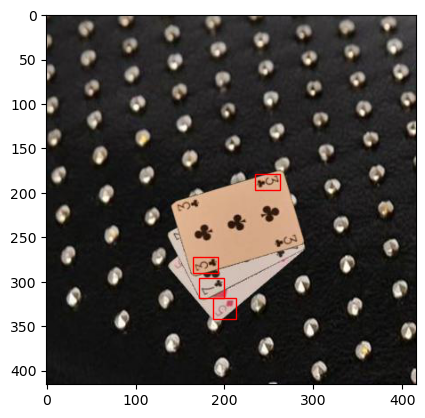

In [13]:
def show_boxes(image_data, show_class=False, ax=None):
    image=image_data['image']
    # convert numpy array to image
    if isinstance(image, torch.Tensor):
        image=image*255
        # convert to uint8
        image= image.type(torch.uint8)
        image=image.numpy()
    if isinstance(image, np.ndarray):
        if image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))
        image=Image.fromarray(image)
        
    # unnormalize image from imagenet stats
    image = np.array(image)
    # permute the channels
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.imshow(image)
    bboxes=image_data["chunck"]
    
    for i in range(len(bboxes)):
        bbox=bboxes.iloc[i]
        xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
        rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='r', facecolor='none')
        if show_class:
            ax.text(xmin, ymin, class_dict[bbox['class']], color='red')
        ax.add_patch(rect)
    return ax

show_boxes(train_data[1])

bboxes before  [[186.75 318.5  213.25 341.5 ]
 [171.75 296.   199.25 318.  ]
 [164.75 272.   193.25 290.  ]
 [234.   178.5  263.   196.5 ]]
bbox after  [(170.5829326923077, 267.96875, 192.87860576923075, 287.3197115384615), (182.3617788461539, 249.03846153846158, 205.4987980769231, 267.5480769230769), (187.4098557692308, 228.8461538461539, 211.38822115384616, 243.9903846153846), (128.72596153846155, 150.18028846153845, 153.12499999999997, 165.3245192307692)]
transformed_image.shape (350, 350, 3)


<Axes: >

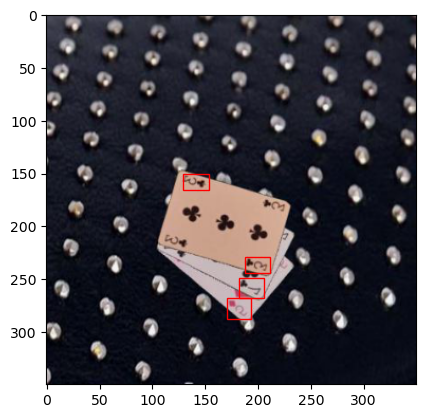

In [14]:
import torch
    
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.RandomScale(scale_limit=0.1, p=0.5),  # Zufällige Skalierung
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),  # Zufällige Verschiebung, Skalierung und Rotation
    A.HorizontalFlip(p=0.5),  # Zufälliges horizontales Flippen
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),  # Zufällige Verschiebung der RGB-Kanäle
    A.RandomBrightnessContrast(p=0.5),  # Zufällige Helligkeits- und Kontrastanpassungen
    A.ColorJitter(p=0.5),  # Weitere zufällige Farbanpassungen
    # imagenet-Statistiken
    
    A.Resize(350, 350)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

image=train_data[1]["image"]
# convert image to numpy array
bboxes=train_data[1]["chunck"][['xmin', 'ymin', 'xmax', 'ymax']].values
print("bboxes before ", bboxes)
# Anwendung der Transformation auf Bild und Bounding Boxes
transformed = transform(image=image, bboxes=bboxes, labels=np.zeros(len(bboxes)))
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
print("bbox after ", transformed_bboxes)

print("transformed_image.shape", transformed_image.shape)

show_boxes({"image": transformed_image, "chunck": pd.DataFrame(transformed_bboxes, columns=['xmin', 'ymin', 'xmax', 'ymax'])})

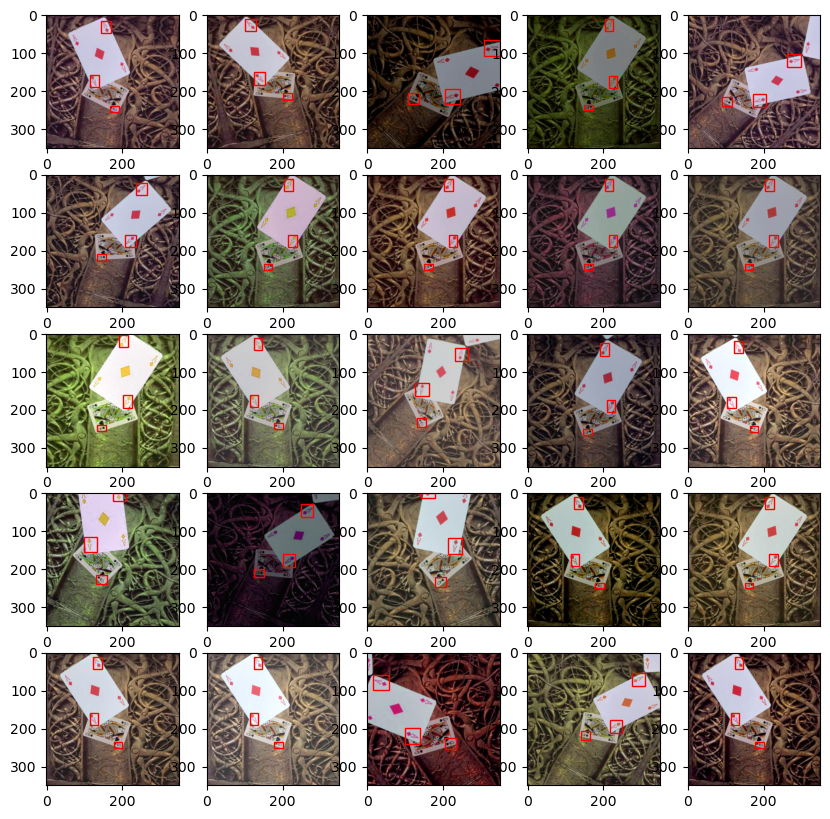

In [15]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.df = df
        self.data = data
        self.size=len(data)
        self.transform = transform
        self.fake_labels=np.zeros(4)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        image = self.data[idx]["image"]
        boxes=self.data[idx]["chunck"][['xmin', 'ymin', 'xmax', 'ymax']].values
        
        target = {}
        
        #transform
        transformed = self.transform(image=image, bboxes=boxes, labels=np.zeros(len(boxes)))
        image=transformed['image']
        
        target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
        if len(target['boxes'])<4:
            target['boxes']=torch.cat((target['boxes'], torch.zeros(4-len(target['boxes']), 4)))
        # permute , channels first using numpy
        image = np.transpose(image, (2, 0, 1))
        image=image/255.0
        # divide values in boxes by image size
        target['boxes'] = target['boxes']/IMAGE_SIZE
        return torch.tensor(image, dtype=torch.float32), target, idx


fig, ax=plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    ds=Dataset(train_data, transform=transform)
    image, target, idx=ds[0]
    target['boxes']=target['boxes']*IMAGE_SIZE
    # unnormalize image from imagenet stats
    bboxes=pd.DataFrame(target['boxes'].numpy(), columns=['xmin', 'ymin', 'xmax', 'ymax'])
    show_boxes({"image": image, "chunck": bboxes}, ax=ax[i//5][i%5])

plt.show()



In [16]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import torch.nn.functional as F


objectness_loss_fn=torch.nn.BCELoss()
mse=torch.nn.MSELoss()

def loss_fun(output, target):
    number_boxes=4
    neurons_per_box=4
    output=output.view(-1, number_boxes, neurons_per_box)
    mse_loss=mse(output*100, target*100)   
    return mse_loss
    

In [17]:
def generate_sample_output(loader, model):
    cols=['xmin', 'ymin', 'xmax', 'ymax']	
    output_data=[]
    for xb, yb, idx in loader:
        xb=xb.to(device)
        yb['boxes']=yb['boxes'].to(device)
        
        output=model(xb)
        for i in range(output.shape[0]):
            # create image from xb tensor
            image=xb[i].detach().cpu().numpy().transpose(1,2,0)
            # convert to PIL
            image=Image.fromarray((image*255).astype(np.uint8))
            df_chunk=pd.DataFrame(columns=cols)
            for j in range(4):            
                x,y,w,h=output[i, j*4:(j+1)*4].detach().cpu().numpy()
                df_chunk.loc[j]=[x,y,w,h]
            output_data.append({
                    'image': image,
                    'chunck': df_chunk*IMAGE_SIZE
                })
        break

    fig, ax=plt.subplots(5, 5, figsize=(20, 20))
    for row in range(5):
        for col in range(5):
            show_boxes(output_data[row*5+col], show_class=False, ax=ax[row, col])
    return fig
        

In [18]:
class MyLightningDataModule(L.LightningDataModule):
    def __init__(self, train_data, valid_data, transform, batch_size=32, num_workers=0):
        super().__init__()
        self.train_data=train_data
        self.valid_data=valid_data
        self.transform=transform
        self.batch_size=batch_size
        self.num_workers=num_workers
        self.train_dataset=Dataset(train_data, transform)
        self.valid_dataset=Dataset(valid_data, transform)
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.valid_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.valid_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [19]:
import torchvision
from torchvision.models import ResNet50_Weights
import torch


class Model(L.LightningModule):
    def __init__(self, loss_fun=None, hidden_size=None, dropout=0.4, params=None, train_dataset=None, val_dataset=None):
        super().__init__()
        self.backbone=torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone_output_size=1000
        number_boxes=4
        self.neurons_per_box=4      
        output_neurons=number_boxes*self.neurons_per_box
        self.loss_fun=loss_fun
        self.params=params
        self.train_dataset=train_dataset
        self.val_dataset=val_dataset
        
        self.head=torch.nn.Sequential(
            torch.nn.Linear(self.backbone_output_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(hidden_size, output_neurons),
            torch.nn.Sigmoid()
        )
              
        # freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.freezed_backbone=True
        
            
    def unfreeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = True
        self.freezed_backbone=False
 
    def forward(self, x):
        x=self.backbone(x)
        x=x.view(-1, self.backbone_output_size)
        x=self.head(x)
        return x
    
    def custom_log(self, name, value):
        self.log(name, value, prog_bar=True, logger=True)
        self.logger.run[name]=value
    
    def training_step(self, batch, batch_idx):
        image, target, _ = batch
        output = self(image)
        loss = self.loss_fun(output, target['boxes'])
        self.custom_log("train_loss", loss.detach())
        self.custom_log("lr", self.trainer.optimizers[0].param_groups[0]['lr'])
        return loss
    
    def validation_step(self, batch, batch_idx):
        image, target, _ = batch
        output = self(image)
        loss = self.loss_fun(output, target['boxes'])
        self.custom_log("val_loss", loss.detach())
        return loss
    
    def on_train_epoch_end(self) -> None:
        epoch=self.current_epoch
        if epoch==self.params['unfreeze_epoch']:
            self.unfreeze_backbone()
        image=generate_sample_output(self.trainer.datamodule.train_dataloader(), self)
        self.logger.run["sample images epoch "+str(epoch)].upload(image)
        return super().on_train_epoch_end()
    
    def configure_optimizers(self):
        print("self.trainer", self.trainer.datamodule.train_dataloader())
        lr=self.params['lr']
        optimizer=torch.optim.AdamW([
            {'params': model.head.parameters(), 'lr':lr}, 
            {'params': model.backbone.layer4.parameters(), 'lr':lr*self.params['layer4_lr_factor']}, 
            {'params': model.backbone.layer3.parameters(), 'lr':lr*self.params['layer3_lr_factor']}, 
            {'params': model.backbone.layer2.parameters(), 'lr':lr*self.params['layer2_lr_factor']}, 
            {'params': model.backbone.layer1.parameters(), 'lr':lr*self.params['layer1_lr_factor']}],
        weight_decay=self.params['wd'])
        scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.params['lr'], steps_per_epoch=len(self.trainer.datamodule.train_dataloader()), epochs=self.params['epochs'])
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }
        
        
from lightning.pytorch.callbacks import ModelCheckpoint


model=Model(hidden_size=1000, loss_fun=loss_fun)
loader=torch.utils.data.DataLoader(ds, batch_size=13, shuffle=True)
for image, target, _ in loader:
    print(image.shape)
    print(image.dtype)
    output=model(image)
    assert output.shape[0]==13, "batch size is not correct, its "+str(output.shape[0])
    print(output.shape) 
    break


torch.Size([13, 3, 350, 350])
torch.float32
torch.Size([13, 16])


In [20]:
import neptune



In [ ]:
from lightning.pytorch.loggers import NeptuneLogger
import neptune

hidden_size=1000
lr=1e-4
wd=0.0001
bs=64
epochs=80
unfreeze_backbone_n_epoch=10
params = {
    "lr": lr, 
    "optimizer": "AdamW", 
    "wd": wd,
    "batch_size": bs,
    "epochs": epochs,
    "unfreeze_epoch": unfreeze_backbone_n_epoch,
    "hidden_size": hidden_size,
    "layer4_lr_factor": 0.01,
    "layer3_lr_factor": 0.01,
    "layer2_lr_factor": 0.001,
    "layer1_lr_factor": 0.001
}
model=Model(hidden_size=hidden_size, loss_fun=loss_fun, params=params, train_dataset=Dataset(train_data, transform), val_dataset=Dataset(valid_data, transform))

neptune_logger = NeptuneLogger(
    project="bernd.heidemann/cards-detection",
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzNjBlYzVkNi0zZTUwLTQ1ODYtODhlNC02NDUxNDg0MDdjNzUifQ==",
    log_model_checkpoints=False
)

neptune_logger.log_hyperparams(params=params)

checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="val_loss",
    mode="min",
    dirpath="models/",
    filename="cards_bbox-{epoch:02d}-{val_loss:.2f}",
)

#run["parameters"] = params

dm=MyLightningDataModule(train_data, valid_data, transform, batch_size=bs, num_workers=16)

trainer=L.Trainer(max_epochs=epochs, logger=neptune_logger, callbacks=[checkpoint_callback])
trainer.fit(model, dm)


In [22]:
generate_sample_output(model.val_dataloader(), model)



MisconfigurationException: `val_dataloader` must be implemented to be used with the Lightning Trainer

In [ ]:
# save model
torch.save(model.state_dict(), "model_"+run["sys/id"].fetch()+".pth")